## Bias due to simple point sources and the CIB

In this example we study the biases to lensing due to two foregrounds: i) randomly positioned point-sources ii) the CIB.

We 
- Generate a random point-source map, and read in a CIB map from websky
- Setup our quadratice estimators using the `setup_recon` function
- Run normal lensing estimator and source-hardened estimators 
- Plot and compare 

Generate point-source map and convert to alm

In [1]:
import os
os.environ["DISABLE_MPI"]="true"
from fgbias import setup_recon, get_bias_terms, get_cl_smooth,dummy_teb, ClBinner
from falafel import utils as futils, qe
import numpy as np
from orphics import maps
import healpy as hp
from pixell import curvedsky, enmap
import matplotlib.pyplot as plt
import healpy as hp

In [2]:
nside=2048
nsource=10000
flux=50. #mJY

#assing to random pixels 
npix = hp.nside2npix(nside)
flux_density_map = np.zeros(hp.nside2npix(nside))
pixel_area = hp.nside2pixarea(nside)
source_pix = np.random.choice(np.arange(npix),size=nsource)
np.add.at(flux_density_map, source_pix, flux/pixel_area)
#flux_density_map is in mJY per sr
#convert to CMB temp units
def flux_density_to_temp(freq):
    #get factor for converting delta flux density in MJy/sr
    #to delta T in CMB units. freq in GHz
    freq = float(freq)
    x = freq / 56.8
    return (1.05e3 * (np.exp(x)-1)**2 *
            np.exp(-x) * (freq / 100)**-4)

source_temp_map = (flux_density_map / 1.e9) * flux_density_to_temp(150.)

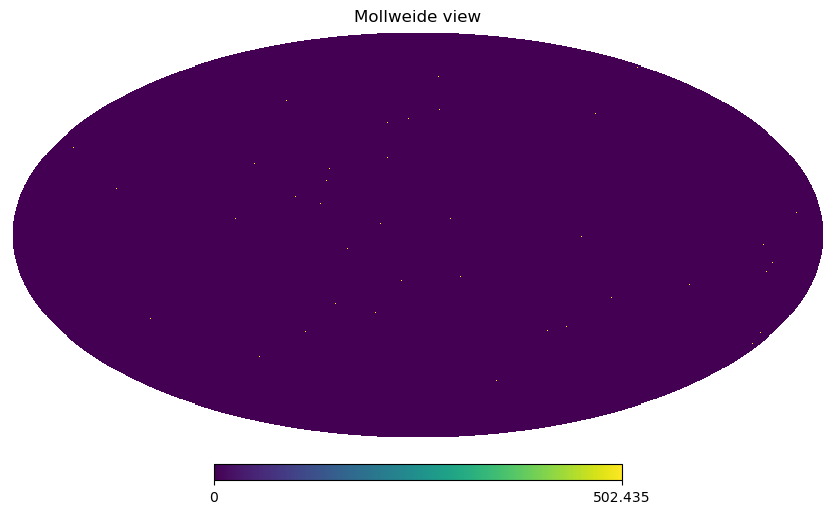

In [3]:
%matplotlib inline

hp.mollview(source_temp_map)

Set some options for the lensing reconstruction

In [4]:
lmin = 100
lmax = 2000
mlmax = 2500

Set noise level and beam (this will enter into to the Cinv filter used for lensing reconstruction)
we're not actually going to add noise to the simulation here

In [5]:
noise_sigma = 5. #muK
beam_fwhm=1.5 #arcmin
ells = np.arange(mlmax+1)
beam = maps.gauss_beam(ells, beam_fwhm)
Nl_tt = (noise_sigma*np.pi/180./60.)**2./beam**2
nells = {"TT":Nl_tt, "EE":2*Nl_tt, "BB":2*Nl_tt}

#use falafel to get theory Cls 
ucls,tcls = futils.get_theory_dicts(grad=True, nells=nells, lmax=mlmax)

Get foreground bias estimates.

We need to get a few things:
- Foreground-only temperature alms. We start with those from the source map we just generated.
- True lensing potential alms (use this to calculate primary bispectrum)
- Two versions of the same unlensed cmb realization, one lensed by the true lensing potential,
one lensed by some different lensing potential.

In [6]:
#source_temp_map_beam_convolved = hp.smoothing(source_temp_map, fwhm=np.radians(beam_fwhm/60))
#source_alm_beamed = hp.map2alm(source_temp_map_beam_convolved,lmax=mlmax)
#source_alm = curvedsky.almxfl(source_alm_beamed, 1./hp.gauss_beam(np.radians(beam_fwhm/60), lmax=mlmax))
source_alm = hp.map2alm(source_temp_map, lmax=mlmax)

Now read in the true $\phi$  and CMB realisations

In [7]:
#from websky
kappa_alm = futils.change_alm_lmax(
    hp.read_alm("/global/cfs/projectdirs/act/data/maccrann/websky/kappa_alm_lmax6000.fits"),
    mlmax)
Ls = np.arange(mlmax+1)
phi_alm = curvedsky.almxfl( kappa_alm, 1./(Ls * (Ls+1) / 2) )

#cmb lensed by true kappa
cmb_alm = dummy_teb(
    hp.read_alm("/global/cfs/projectdirs/act/data/maccrann/websky/lensed_cmb/lensed_cmb_alm_websky_cmb1999_lmax6000.fits"),
)

#same cmb lensed by a different kappa
cmbp_alm = futils.get_cmb_alm(1999,0)

/tmp/ipykernel_932788/3072968097.py:6: RuntimeWarning: divide by zero encountered in divide
  phi_alm = curvedsky.almxfl( kappa_alm, 1./(Ls * (Ls+1) / 2) )


Setup lensing reconstruction stuff. This generates `recon_setup`, a dictionary that contains various useful quantities functions, 
including those that perform lensing reconstruction using falafel.

In [8]:
shape, wcs = enmap.fullsky_geometry(res=np.radians(2. / 60.0))
px_car = qe.pixelization(shape, wcs) #the pixelisation to use for the real-space quadratic estimator (shouldn't affect the result...much).

#px_hp = qe.pixelization(nside=2048) #the pixelisation to use for the real-space quadratic estimator (shouldn't affect the result...much).
recon_setup = setup_recon(px_car, lmin, lmax, mlmax,
                tcls,
                do_psh=True, do_prh=False,
                profile=None)

use new TT
 Response (TT)


Now use `get_bias_terms` to get the lensing foreground bias. This will take ~5 minutes I'm afraid. Sorry. 

In [9]:
from timeit import default_timer as timer
import datetime

start=timer()
source_bias_stuff = get_bias_terms(source_alm, recon_setup, 
                   phi_alm, cmb_alm, cmbp_alm,
                   ests=["qe","psh"], comm=None)
end=timer()
print("took %s to get bias terms"%datetime.timedelta(seconds=end-start))

getting biases for est: qe
doing fg-only reconstruction
qfunc: <function setup_AAAA_recon.<locals>.qfunc_tt_qe at 0x7f6e5dd77250>


/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:284: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc tr

doing secondary


/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:284: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc tr

getting biases for est: psh
doing fg-only reconstruction
qfunc: <function setup_AAAA_recon.<locals>.qfunc_tt_psh at 0x7f6e5dc7dcf0>


/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:284: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc tr

doing secondary


/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:284: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc tr

 Response (TT)
returning outputs
took 0:02:44.478742 to get bias terms


/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/fgbias/reconstruction.py:207: RuntimeWarning: invalid value encountered in divide
  N0 = norm_lens[i]**2/norm_fg[i]
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/fgbias/reconstruction.py:208: RuntimeWarning: invalid value encountered in divide
  N0_s = norm_src**2/norm_src_fg


`source_bias_stuff` is a dictionary containing the various outputs of `get_bias_terms`. 
Let's plot some of these outputs. We'll divide the total bias and each of the components by the theory $C_L^{\phi\phi}$

## Compare qe (i.e. normal estimator) and point-source hardened estimators

/tmp/ipykernel_500526/3845246384.py:7: RuntimeWarning: invalid value encountered in divide
  cl_phiphi_theory = ucls["kk"] / (Ls * (Ls+1) / 2)**2 #get theory to compare to


Text(0.5, 1.0, 'Point sources')

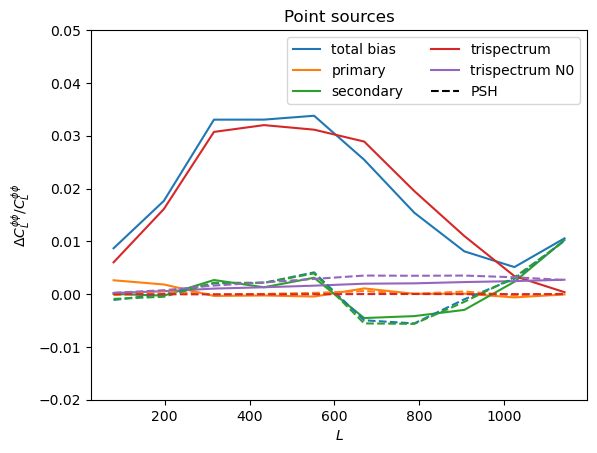

In [13]:
fig,ax=plt.subplots()

#function for binning Cl
binner = ClBinner(lmin=20, lmax=1200, nbin=10)

#get true cl_phi_phi to compare biases to
cl_phiphi_theory = ucls["kk"] / (Ls * (Ls+1) / 2)**2 #get theory to compare to
cl_phiphi_binned = binner(cl_phiphi_theory)

est, linestyle = "qe","-"
#ax.plot(binner.bin_mids, binner(bias_stuff["cl_phi"]), color="k", label=r"$C_L^{\phi\phi}$")
ax.plot(binner.bin_mids, binner(source_bias_stuff["total_%s"%est])/cl_phiphi_binned, linestyle, color="C0", label="total bias")
ax.plot(binner.bin_mids, binner(source_bias_stuff["primary_%s"%est])/cl_phiphi_binned, linestyle, color="C1", label="primary")
ax.plot(binner.bin_mids, binner(source_bias_stuff["secondary_%s"%est])/cl_phiphi_binned, linestyle, color="C2", label="secondary")
ax.plot(binner.bin_mids, binner(source_bias_stuff["trispectrum_%s"%est])/cl_phiphi_binned, linestyle, color="C3", label="trispectrum")
#ax.plot(binner.bin_mids, binner(source_bias_stuff["tri_N0_%s"%est])/cl_phiphi_binned, linestyle,color="C4", label="trispectrum N0")

est, linestyle = "psh","--"
#ax.plot(binner.bin_mids, binner(bias_stuff["cl_phi"]), color="k", label=r"$C_L^{\phi\phi}$")
ax.plot(binner.bin_mids, binner(source_bias_stuff["total_%s"%est])/cl_phiphi_binned, linestyle, color="C0",)# label="total bias")
ax.plot(binner.bin_mids, binner(source_bias_stuff["primary_%s"%est])/cl_phiphi_binned, linestyle,color="C1",) # label="primary")
ax.plot(binner.bin_mids, binner(source_bias_stuff["secondary_%s"%est])/cl_phiphi_binned, linestyle,color="C2",)# label="secondary")
ax.plot(binner.bin_mids, binner(source_bias_stuff["trispectrum_%s"%est])/cl_phiphi_binned, linestyle,color="C3",)# label="trispectrum")
#ax.plot(binner.bin_mids, binner(source_bias_stuff["tri_N0_%s"%est])/cl_phiphi_binned, linestyle,color="C4",)# label="trispectrum")
ax.plot([],[],'k--',label="PSH")

ax.set_ylim([-0.02,0.05])
#ax.set_yscale('symlog')
ax.legend(ncols=2)
ax.set_xlabel(r"$L$")
ax.set_ylabel(r"$\Delta C_L^{\phi\phi} / C_L^{\phi\phi}$")
ax.set_title(r"Point sources")

### Things to note
- Solid lines are for QE, dashed lines for point-source hardening. Point-source hardening works!
- There's only trispectrum bias for this case because the sources were not correlated with the 
lensing potential. However, the estimate of th secondary seems noisy...look into this - I wonder if 
we need to average over more CMB realisations?

Let's try with websky CIB instead. Read in from file, convert to alm, and compute bias terms. 
I'm also going to mask bright sources (flux > 10mJY), otherwise trispectrum will dominate and it will look
very similar to the point source case

In [37]:
websky_cib_map = hp.read_map("/global/cfs/projectdirs/act/data/maccrann/websky/cib_nu0145.fits")
#this is in MJy/sr. Convert to flux and (crudely) mask bright sources
flux_map = websky_cib_map * 1.e9 * hp.nside2pixarea(hp.npix2nside(len(websky_cib_map)))
bright_source = flux_map > 10.
websky_cib_map[bright_source] = websky_cib_map[~bright_source].mean()

#convert to temperature units and alm
websky_cib_temp_map = flux_density_to_temp(145.) * websky_cib_map
websky_cib_alm = hp.map2alm(websky_cib_temp_map, lmax=mlmax)

In [38]:
start=timer()
cib_bias_stuff = get_bias_terms(websky_cib_alm, recon_setup, 
                   phi_alm, cmb_alm, cmbp_alm,
                   ests=["qe","psh"], comm=None)
end=timer()
print("took %s to get bias terms"%datetime.timedelta(seconds=end-start))

getting biases for est: qe
doing fg-only reconstruction
qfunc: <function setup_AAAA_recon.<locals>.qfunc_tt_qe at 0x7f6e18efdb40>


/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:284: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc tr

doing secondary


/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:284: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc tr

getting biases for est: psh
doing fg-only reconstruction
qfunc: <function setup_AAAA_recon.<locals>.qfunc_tt_psh at 0x7f6e18eff400>


/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:284: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc tr

doing secondary


/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:284: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc tr

 Response (TT)
returning outputs
took 0:03:14.820641 to get bias terms


/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/fgbias/reconstruction.py:207: RuntimeWarning: invalid value encountered in divide
  N0 = norm_lens[i]**2/norm_fg[i]
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/fgbias/reconstruction.py:208: RuntimeWarning: invalid value encountered in divide
  N0_s = norm_src**2/norm_src_fg


### Plot CIB lensing biases

Text(0.5, 1.0, 'CIB biases')

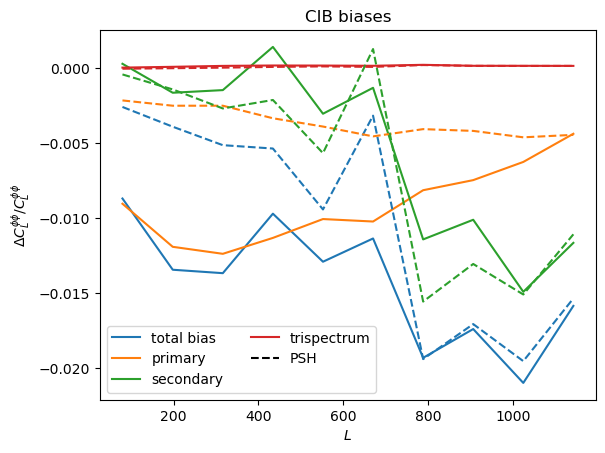

In [41]:
fig,ax=plt.subplots()

est, linestyle = "qe","-"
qe_fac=1.
#ax.plot(binner.bin_mids, binner(bias_stuff["cl_phi"]), color="k", label=r"$C_L^{\phi\phi}$")
ax.plot(binner.bin_mids,qe_fac*binner(cib_bias_stuff["total_%s"%est])/cl_phiphi_binned, linestyle, color="C0", label="total bias")
ax.plot(binner.bin_mids, qe_fac*binner(cib_bias_stuff["primary_%s"%est])/cl_phiphi_binned, linestyle, color="C1", label="primary")
ax.plot(binner.bin_mids, qe_fac*binner(cib_bias_stuff["secondary_%s"%est])/cl_phiphi_binned, linestyle, color="C2", label="secondary")
ax.plot(binner.bin_mids, qe_fac*binner(cib_bias_stuff["trispectrum_%s"%est])/cl_phiphi_binned, linestyle, color="C3", label="trispectrum")
#ax.plot(binner.bin_mids, qe_fac*binner(cib_bias_stuff["tri_N0_%s"%est])/cl_phiphi_binned, linestyle,color="C4", label="trispectrum N0")

est, linestyle = "psh","--"
#ax.plot(binner.bin_mids, binner(bias_stuff["cl_phi"]), color="k", label=r"$C_L^{\phi\phi}$")
ax.plot(binner.bin_mids, binner(cib_bias_stuff["total_%s"%est])/cl_phiphi_binned, linestyle, color="C0",)# label="total bias")
ax.plot(binner.bin_mids, binner(cib_bias_stuff["primary_%s"%est])/cl_phiphi_binned, linestyle,color="C1",) # label="primary")
ax.plot(binner.bin_mids, binner(cib_bias_stuff["secondary_%s"%est])/cl_phiphi_binned, linestyle,color="C2",)# label="secondary")
ax.plot(binner.bin_mids, binner(cib_bias_stuff["trispectrum_%s"%est])/cl_phiphi_binned, linestyle,color="C3",)# label="trispectrum")
#ax.plot(binner.bin_mids, binner(cib_bias_stuff["tri_N0_%s"%est])/cl_phiphi_binned, linestyle,color="C4",)# label="trispectrum")
ax.plot([],[],'k--',label="PSH")

#ax.set_ylim([-0.05,0.1])
#ax.set_yscale('symlog')
ax.legend(ncols=2)
ax.set_xlabel(r"$L$")
ax.set_ylabel(r"$\Delta C_L^{\phi\phi} / C_L^{\phi\phi}$")
ax.set_title("CIB biases")

### Things to note
- Since we masked the bright sources, the trispectrum contribution is now negligble. Probably we'd start to see it again if we used high cmb $l$.
- Point-source hardening helps with the primary, but not the secondary. 